In [22]:
import pandas as pd # type: ignore
import json
import re
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt

### Import the data and make it workable

In [2]:
# append_paths = [f'../data/raw/by_pages/page_{page_num}_apps.json' for page_num in range(0,3000)]
# apps = []
# for page_path in append_paths:
#     page = json.loads(open(page_path, 'r').read())
#     apps.extend(page)
# with open('workable_apps.json','w')as f:
#     json.dump(apps, f, indent=4)


In [3]:
with open('workable_apps.json','r')as f:
    apps = json.loads(f.read())


In [4]:
df = pd.DataFrame([app for app in apps if app])
df.shape

(16463, 13)

In [5]:
n_na = df.isna().sum(axis=0)
n_na.round(2)  # Percentage of missing values

name                   0
category               0
developer           1064
release              138
setup_size             5
setup_type             7
compatibility        103
operating_system     228
ram_required         228
hdd_space            228
cpu                  228
desc                   0
features               0
dtype: int64

In [49]:
df.head(5)

,name,category,developer,release,setup_size,setup_type,compatibility,operating_system,ram_required,hdd_space,cpu,desc,features
0,EssentialPIM Pro Business 2024,Management,EssentialPIM Pro,22th Jun 2024,32 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,200 MB,Intel Dual Core or higher processor,EssentialPIM Pro Business 2024 is a profession...,"Allows you to create a wide range of tasks, no..."
1,Gillmeister Rename Expert 2024,Utilities,Gillmeister,22th Jun 2024,15 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,Intel Dual Core or higher processor,Gillmeister Rename Expert 2024 is a profession...,Allows you to edit the names of files and fold...
2,iToolab WatsG 2024 Free Download,File Sharing,iToolab,22th Jun 2024,72 MB,Offline Installer / Full Standalone Setup:,32 Bit (x86) / 64 Bit (x64),Windows 7/8/8.1/10/11.,512 MB of RAM required.,250 MB of free space required.,Intel Dual Core or higher processor.,iToolab WatsG 2024 is a fantastic file sharing...,Easily transfer WhatsApp data from Android and...
3,ProPresenter 2024,Multimedia,ProPresenter,22th Jun 2024,80 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,Intel Dual Core or higher processor,ProPresenter 2024 is a powerful application wh...,Allows you to view and watch live events in ex...
4,DbVisualizer Pro 2024,"Database, Development",DbVisualizer Pro,22th Jun 2024,209 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,2 GB,1 GB,Intel Dual Core or higher processor,DbVisualizer Pro 2024 is a professional databa...,"Allows database developers to create, edit, up..."


In [48]:
df['category'].str.find(',')

0       -1
1       -1
2       -1
3       -1
4        8
        ..
16458   -1
16459   -1
16460   -1
16461   -1
16462   -1
Name: category, Length: 16463, dtype: int64

### We can clean the columns with units example: hdd_space, ram, setup size, and also cpu

#### These are some cleaning functions

In [7]:
def parse_memory(x: str):
   try:
      # Extract the number part from the string
      number = re.search(r'\d+(\.\d+)?', x).group()
      number = float(number)  # Convert the extracted number to a float
   except (AttributeError, ValueError, TypeError):
      return np.nan  # Return NaN if no valid number is found

   # Determine the unit and convert accordingly
   if re.search(r'(MB|mb)', x):
      return number
   elif re.search(r'(KB|kb)', x):
      return number / 1000
   elif re.search(r'(GB|gb)', x):
      return number * 1000
   return np.nan 

def parse_compatibility(x: str):
   try:
      matches =  re.findall(r'(32|64|86)', x)
   except TypeError:
      return np.nan
   if matches:
      if '86' in matches:
         matches.remove('86')
         matches.insert(0, '32')
      matches = list(set(matches))
      matches = [int(num) for num in matches]
      return min(matches)
   else:
      return np.nan
   
def parse_date(date):
    try:
        # Remove 'rd', 'th', 'st' from the day part
        cleaned_date_str = re.sub(r'(st|nd|rd|th)', '', date)

        # Parse the cleaned date string
        date_obj = datetime.strptime(cleaned_date_str, "%d %b %Y")
        return date_obj.strftime('%d-%m-%Y')
    except (ValueError, TypeError):
        return np.nan
    
def categorize_os(value):
   try:  
      if re.search(r"7/8/8\.1/10", value):
         return "Modern Versions"
      elif re.search(r"7/8/10", value):
         return "Modern Versions"
      elif re.search(r"(2000/)?XP/Vista/7/8(/8\.1)?/10", value):
         return "All Windows versions"
      elif re.search(r"XP/Vista/7", value):
         return "Older Windows versions"
      else:
         return "Other"
   except TypeError:
      return np.nan


In [8]:
newdf = df.copy()

In [9]:
newdf['setup_size_MB'] = newdf['setup_size'].map(parse_memory)
newdf['hdd_space_MB'] = newdf['hdd_space'].map(parse_memory)
newdf['ram_required_MB'] = newdf['ram_required'].map(parse_memory)
newdf['minimum_os_bits']  = newdf['compatibility'].map(parse_compatibility)
newdf['release'] = newdf['release'].map(parse_date)
newdf['os_version'] = newdf['operating_system'].map(categorize_os)
newdf = newdf.drop(['setup_size', 'setup_type','compatibility', 'operating_system', 'ram_required', 'hdd_space'], axis=1)

In [10]:
newdf.query('release == "03-09-3030"')
newdf = newdf.drop(8182)
newdf['release'] = pd.to_datetime(newdf['release'], dayfirst=True)

In [11]:
newdf['category'] = newdf['category'].astype("category")
newdf['os_version'] = newdf['os_version'].astype("category")
newdf['developer'] = newdf['developer'].astype("category")

<class 'pandas.core.frame.DataFrame'>
Index: 16462 entries, 0 to 16462
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16462 non-null  object        
 1   category         16462 non-null  category      
 2   developer        15398 non-null  category      
 3   release          14482 non-null  datetime64[ns]
 4   cpu              16234 non-null  object        
 5   desc             16462 non-null  object        
 6   features         16462 non-null  object        
 7   setup_size_MB    16273 non-null  float64       
 8   hdd_space_MB     16210 non-null  float64       
 9   ram_required_MB  16209 non-null  float64       
 10  minimum_os_bits  16171 non-null  float64       
 11  os_version       16234 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(4), object(4)
memory usage: 1.7+ MB


In [13]:
newdf = newdf.dropna().reset_index(drop=True)

In [23]:
newdf.shape

(13642, 12)

Text(0.5, 0, 'App count')

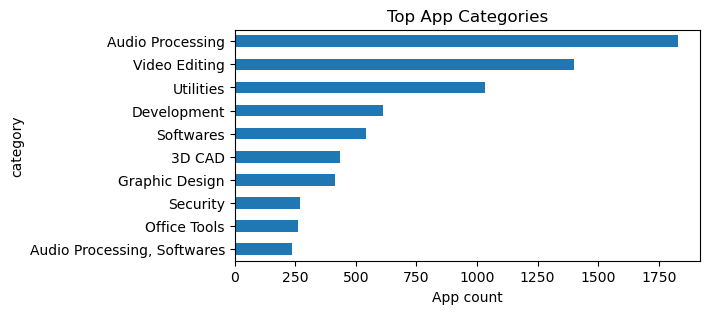

In [36]:
import seaborn as sns
plt.figure(figsize=(6,3))
ax = newdf.category.value_counts().nlargest(10).sort_values(ascending=True).plot.barh()
ax.set_title("Top App Categories")
ax.set_xlabel("App count")

In [40]:
newdf[newdf.developer == 'Homepage']

,name,category,developer,release,cpu,desc,features,setup_size_MB,hdd_space_MB,ram_required_MB,minimum_os_bits,os_version
3459,The Foundry Nuke Studio 2021,Development,Homepage,2022-09-28,Intel Dual Core processor or later.,The Foundry Nuke Studio 2021 is a node based c...,"Application with node bass composition, creati...",1800.0,2000.0,512.0,64.0,Modern Versions
4065,Foxit PDF Editor Pro 2021,PDF Editors,Homepage,2022-06-04,Intel Dual Core processor or later.,Foxit PDF Editor Pro 2021 is a versatile appli...,Simple and easy to manage and handle with PDF ...,809.0,1000.0,512.0,32.0,Modern Versions
4255,Topaz Video Enhance AI 2021,Video Editing,Homepage,2022-04-27,Intel Dual Core processor or later.,Topaz Video Enhance AI 2021 is a widely used a...,Enhance and improve video quality with ease. H...,2800.0,3000.0,512.0,64.0,Modern Versions
4491,CLIP STUDIO PAINT EX 2021,Photo Editing,Homepage,2022-03-10,Intel Dual Core processor or later.,CLIP STUDIO PAINT EX 2021 is an application th...,"Design and create creative arts, and more. Eas...",408.0,500.0,512.0,64.0,Modern Versions
4496,Autodesk AutoCAD MEP 2022,3D CAD,Homepage,2022-03-10,Intel Dual Core processor or later.,Autodesk AutoCAD MEP 2022 is a versatile appli...,MEP tools with AutoCAD. Simple and easy to use...,6200.0,7000.0,512.0,64.0,Modern Versions
...,...,...,...,...,...,...,...,...,...,...,...,...
12707,WinUtilities Professional Edition Portable,System Tuning,Homepage,2016-08-11,1 GHz Processor or faster,WinUtilities Professional Edition is handy sof...,It’s superb optimizing software. It has a numb...,11.1,15.0,128.0,32.0,Modern Versions
12708,USB Flash Drive Data Recovery Portable,Data Recovery,Homepage,2016-08-11,Intel Pentium 4 or later.,USB Drive Data Recovery is an impressive appli...,Imposing data recovery application. Recovers l...,25.6,50.0,256.0,32.0,Modern Versions
12709,High-Logic FontCreator Professional Portable,Utilities,Homepage,2016-08-11,Intel Pentium 4 or later.,High-Logic FontCreator Professional is an impo...,Impressive application for creating your own f...,26.2,50.0,512.0,32.0,Modern Versions
12715,EaseUS Data Recovery Wizard 10.5.0 Technician ...,Data Recovery,Homepage,2016-08-11,Intel Pentium 4 or later.,EaseUS Data Recovery Wizard 10.5.0 Technician ...,Powerful and comprehensive recovery tool. Reli...,15.1,50.0,128.0,32.0,Modern Versions
